# Data and main parameters

In [73]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
# !git clone https://github.com/lqwic/deep_var.git
# %cd deep_var/

In [102]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

alpha = 99
train_size = 0.8
data = stocks

# Test Model

In [103]:
class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.GRU(input_size=input_size + latent_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_mu = nn.Linear(hidden_size, latent_size)
        self.encoder_log_var = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        self.decoder = nn.GRU(input_size=latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu = nn.Linear(hidden_size, input_size)
        self.decoder_log_var = nn.Linear(hidden_size, input_size)
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        z_prev = torch.zeros(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
        
        z_list = []
        r_list = []
        mu_z_list = []
        log_var_z_list = []
        
        for t in range(seq_length):
            # Encoder
            _, h_enc = self.encoder(torch.cat([x[:, t, :].unsqueeze(1), z_prev.unsqueeze(1)], dim=-1), h_enc)
            h_enc = self.dropout(h_enc)
            mu_z = self.encoder_mu(h_enc[-1])
            log_var_z = self.encoder_log_var(h_enc[-1])
            z = self.reparameterize(mu_z, log_var_z)
            z_list.append(z)
            mu_z_list.append(mu_z)
            log_var_z_list.append(log_var_z)
            z_prev = z
            
            # Decoder
            _, h_dec = self.decoder(torch.cat([z.unsqueeze(1), r_prev.unsqueeze(1)], dim=-1), h_dec)
            h_dec = self.dropout(h_dec)
            mu_r = self.decoder_mu(h_dec[-1])
            log_var_r = self.decoder_log_var(h_dec[-1])
            r = self.reparameterize(mu_r, log_var_r)
            r_list.append(r)
            r_prev = x[:, t, :]
        
        z_list = torch.stack(z_list, dim=1)
        r_list = torch.stack(r_list, dim=1)
        mu_z_list = torch.stack(mu_z_list, dim=1)
        log_var_z_list = torch.stack(log_var_z_list, dim=1)
        
        kld_loss = self.kld_loss(mu_z_list, log_var_z_list)
        recon_loss = self.reconstruction_loss(r_list, x)
        
        return kld_loss, recon_loss, z_list, r_list, mu_z_list, log_var_z_list
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def kld_loss(self, mu, log_var):
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return kld
    
    def reconstruction_loss(self, r, x):
        recon_loss = F.mse_loss(r, x, reduction='sum')
        return recon_loss

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(13, 16, 10, 1).to(device)

r_prev = torch.rand(1, 21, 13).to(device)
print(model(r_prev)[3][0][0])
print(r_prev[0][0])

tensor([ 1.3041, -1.2267, -1.3925, -0.0145, -1.4841, -0.5854,  0.3461,  1.9310,
        -1.0031,  2.5608,  0.2846, -0.6695, -0.1557],
       grad_fn=<SelectBackward0>)
tensor([0.7672, 0.4054, 0.9992, 0.3226, 0.4056, 0.1064, 0.7875, 0.6560, 0.2741,
        0.9650, 0.7475, 0.0636, 0.4465])


# Model

In [105]:
class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.GRU(input_size=input_size + latent_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_mu = nn.Linear(hidden_size, latent_size)
        self.encoder_log_var = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        self.decoder = nn.GRU(input_size=latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu = nn.Linear(hidden_size, input_size)
        self.decoder_log_var = nn.Linear(hidden_size, input_size)
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        z_prev = torch.zeros(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
        
        z_list = []
        r_list = []
        mu_z_list = []
        log_var_z_list = []
        
        for t in range(seq_length):
            # Encoder
            _, h_enc = self.encoder(torch.cat([x[:, t, :].unsqueeze(1), z_prev.unsqueeze(1)], dim=-1), h_enc)
            h_enc = self.dropout(h_enc)
            mu_z = self.encoder_mu(h_enc[-1])
            log_var_z = self.encoder_log_var(h_enc[-1])
            z = self.reparameterize(mu_z, log_var_z)
            z_list.append(z)
            mu_z_list.append(mu_z)
            log_var_z_list.append(log_var_z)
            z_prev = z
            
            # Decoder
            _, h_dec = self.decoder(torch.cat([z.unsqueeze(1), r_prev.unsqueeze(1)], dim=-1), h_dec)
            h_dec = self.dropout(h_dec)
            mu_r = self.decoder_mu(h_dec[-1])
            log_var_r = self.decoder_log_var(h_dec[-1])
            r = self.reparameterize(mu_r, log_var_r)
            r_list.append(r)
            r_prev = x[:, t, :]
        
        z_list = torch.stack(z_list, dim=1)
        r_list = torch.stack(r_list, dim=1)
        mu_z_list = torch.stack(mu_z_list, dim=1)
        log_var_z_list = torch.stack(log_var_z_list, dim=1)
        
        kld_loss = self.kld_loss(mu_z_list, log_var_z_list)
        recon_loss = self.reconstruction_loss(r_list, x)
        
        return kld_loss, recon_loss, z_list, r_list, mu_z_list, log_var_z_list
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def kld_loss(self, mu, log_var):
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return kld
    
    def reconstruction_loss(self, r, x):
        recon_loss = F.mse_loss(r, x, reduction='sum')
        return recon_loss

# Training

In [106]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    sequences = torch.tensor(sequences, dtype=torch.float32)
    train_size = int(train_ratio * len(sequences))
    train_data = sequences[:train_size]
    test_data = sequences[train_size - seq_length:]
    train_dataset = TensorDataset(train_data)
    test_dataset = TensorDataset(test_data)
    return train_dataset, test_dataset

def train(model, train_loader, optimizer, device=torch.device('cpu')):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    for batch in train_loader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        kld_loss, recon_loss, _, _, _, _ = model(batch)
        loss = kld_loss + recon_loss
        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kld_loss.item()
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_kl_loss /= len(train_loader.dataset)
    
    return train_loss, train_recon_loss, train_kl_loss

def test(model, test_loader, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].to(device)
            kld_loss, recon_loss, _, _, _, _ = model(batch)
            loss = kld_loss + recon_loss
            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kld_loss.item()
    
    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_kl_loss /= len(test_loader.dataset)
    
    return test_loss, test_recon_loss, test_kl_loss

In [107]:
seq_length = 21
batch_size = 256

train_dataset, test_dataset = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 9616.2768, Train Recon Loss: 9545.0439, Train KL Loss: 71.2330, Test Loss: 7991.8697, Test Recon Loss: 7932.0585, Test KL Loss: 59.8114
Epoch [20/1000], Train Loss: 8629.4637, Train Recon Loss: 8601.0331, Train KL Loss: 28.4306, Test Loss: 7210.5524, Test Recon Loss: 7189.9572, Test KL Loss: 20.5951
Epoch [30/1000], Train Loss: 7412.4910, Train Recon Loss: 7284.9988, Train KL Loss: 127.4922, Test Loss: 6219.1336, Test Recon Loss: 6115.9710, Test KL Loss: 103.1626
Epoch [40/1000], Train Loss: 6720.3205, Train Recon Loss: 6611.9413, Train KL Loss: 108.3791, Test Loss: 5846.5560, Test Recon Loss: 5753.1206, Test KL Loss: 93.4353
Epoch [50/1000], Train Loss: 6392.7087, Train Recon Loss: 6301.5377, Train KL Loss: 91.1710, Test Loss: 5683.3703, Test Recon Loss: 5606.6141, Test KL Loss: 76.7562
Epoch [60/1000], Train Loss: 6170.6822, Train Recon Loss: 6097.0230, Train KL Loss: 73.6592, Test Loss: 5549.5144, Test Recon Loss: 5485.6273, Test KL Loss: 63.8870
Epoch [

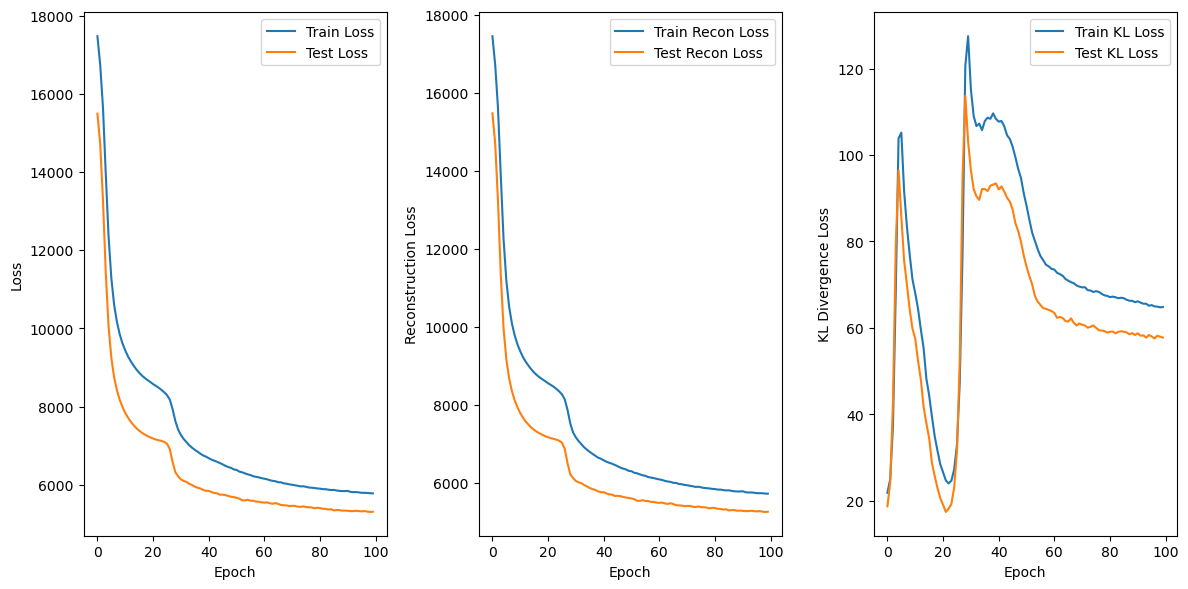

Epoch [110/1000], Train Loss: 5732.2598, Train Recon Loss: 5668.2589, Train KL Loss: 64.0009, Test Loss: 5318.4293, Test Recon Loss: 5261.5336, Test KL Loss: 56.8956
Epoch [120/1000], Train Loss: 5687.1955, Train Recon Loss: 5623.7522, Train KL Loss: 63.4434, Test Loss: 5267.3198, Test Recon Loss: 5210.0296, Test KL Loss: 57.2902
Epoch [130/1000], Train Loss: 5643.6449, Train Recon Loss: 5581.4387, Train KL Loss: 62.2063, Test Loss: 5275.6624, Test Recon Loss: 5219.1856, Test KL Loss: 56.4768
Epoch [140/1000], Train Loss: 5606.7617, Train Recon Loss: 5544.5904, Train KL Loss: 62.1714, Test Loss: 5260.0427, Test Recon Loss: 5203.7807, Test KL Loss: 56.2621
Epoch [150/1000], Train Loss: 5577.9047, Train Recon Loss: 5516.2285, Train KL Loss: 61.6763, Test Loss: 5260.4911, Test Recon Loss: 5204.4492, Test KL Loss: 56.0419
Epoch [160/1000], Train Loss: 5542.8356, Train Recon Loss: 5481.4477, Train KL Loss: 61.3878, Test Loss: 5248.0619, Test Recon Loss: 5192.0788, Test KL Loss: 55.9830
Epoc

In [ ]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
num_layers = 1
learning_rate = 0.001
epochs = 1000
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'gaussvae_checkpoints'
os.makedirs(save_dir, exist_ok=True)

model.train()
train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_kl_losses = []
test_kl_losses = []

# torch.autograd.set_detect_anomaly(True)

for epoch in trange(1, epochs+1):
    train_loss, train_recon_loss, train_kl_loss = train(model, train_loader, optimizer, device)
    test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}")
    
    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    
    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training Plot

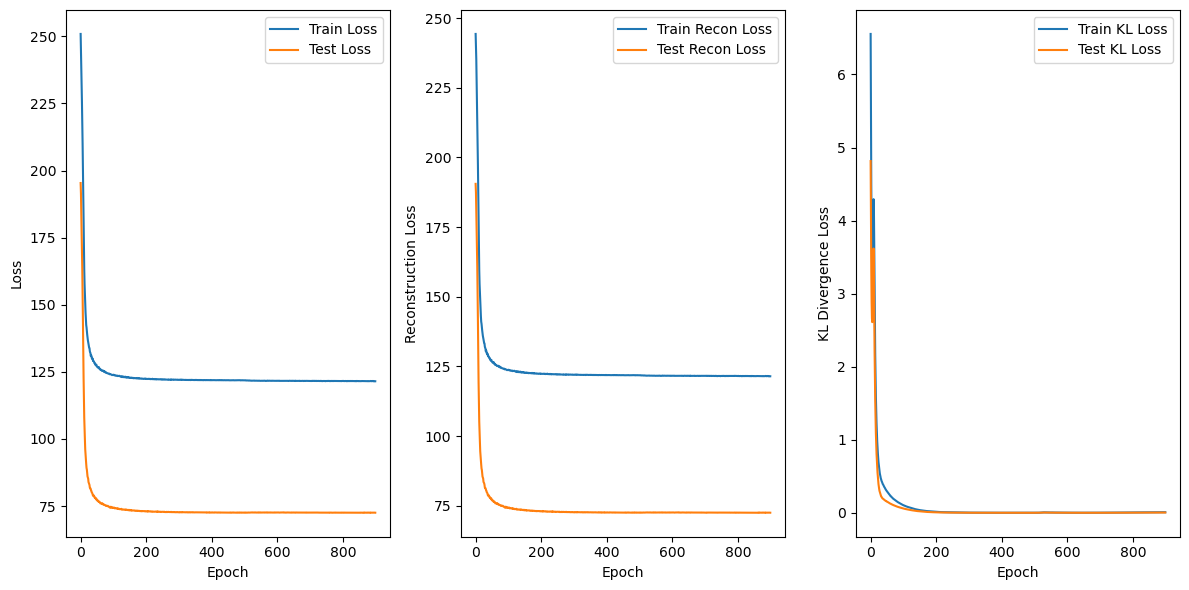

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses[:900], label='Train Loss')
plt.plot(test_losses[:900], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_recon_losses[:900], label='Train Recon Loss')
plt.plot(test_recon_losses[:900], label='Test Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_kl_losses[:900], label='Train KL Loss')
plt.plot(test_kl_losses[:900], label='Test KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f"GaussVAE_training_plot.png")
plt.show()

# Final model

In [85]:
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load('gaussvae_checkpoints/model_epoch_900.pth'))

<All keys matched successfully>

# Testing randomness

In [87]:
x = torch.rand(1, 21, input_dim).to(device)

with torch.no_grad():
    model.eval()
    kl_loss, rec_loss, z_list, r_list, mu_z_list, log_sigma_z_list = model(x)

print(f"Input sequence (x) of {x.shape}:")
print(x[0][0])
print(f"Generated r_list of {r_list.shape}:")
print(r_list[0][0])

Input sequence (x) of torch.Size([1, 21, 5]):
tensor([0.2648, 0.8282, 0.2625, 0.7816, 0.1093])
Generated r_list of torch.Size([1, 21, 5]):
tensor([-0.0652,  0.0247, -0.0514,  0.0225,  0.0280])


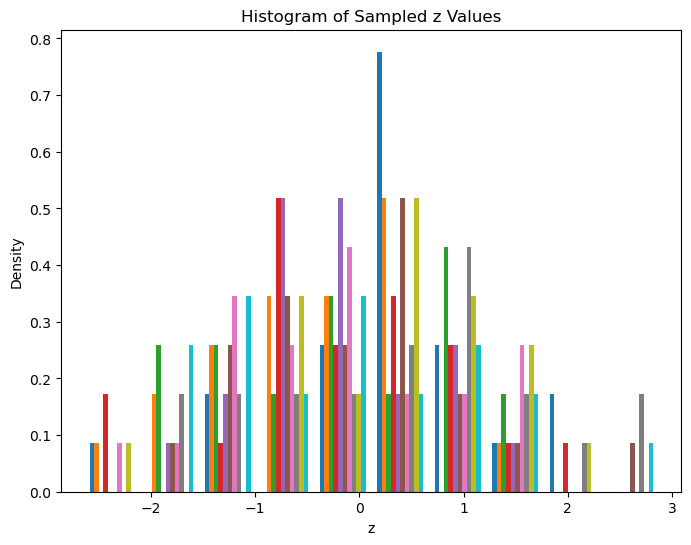

In [88]:
z_samples = torch.zeros_like(mu_z_list)
for t in range(mu_z_list.size(1)):
    z_samples[:, t, :] = model.reparameterize(mu_z_list[:, t, :], log_sigma_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show()

# VaR Forecasting

In [89]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()

DSVM(
  (encoder): GRU(15, 16, batch_first=True)
  (encoder_mu): Linear(in_features=16, out_features=10, bias=True)
  (encoder_log_var): Linear(in_features=16, out_features=10, bias=True)
  (decoder): GRU(15, 16, batch_first=True)
  (decoder_mu): Linear(in_features=16, out_features=5, bias=True)
  (decoder_log_var): Linear(in_features=16, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [122]:
portfolio_weights = np.random.rand(data.shape[1])
portfolio_weights /= np.sum(portfolio_weights)
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)

In [90]:
portfolio_weights = np.loadtxt('weights_commodities99.csv', delimiter=',')

In [91]:
def one_step_ahead_forecast(model, historical_returns, portfolio_weights, num_samples=1000, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        # historical_returns = historical_returns.unsqueeze(0).to(device)
        
        batch_size, seq_length, _ = historical_returns.shape
        h_enc = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        z_prev = torch.zeros(batch_size, model.latent_size).to(device)
        
        for t in range(seq_length):
            _, h_enc = model.encoder(torch.cat([historical_returns[:, t, :].unsqueeze(1), z_prev.unsqueeze(1)], dim=-1), h_enc)
            mu_z = model.encoder_mu(h_enc[-1])
            log_var_z = model.encoder_log_var(h_enc[-1])
            z_prev = model.reparameterize(mu_z, log_var_z)
        
        z_samples = []
        for _ in range(num_samples):
            eps = torch.randn_like(z_prev)
            z_sample = model.reparameterize(mu_z, eps)
            z_samples.append(z_sample)
        z_samples = torch.stack(z_samples)
        
        forecasts = []
        for z_sample in z_samples:
            _, h_dec = model.decoder(torch.cat([z_sample.unsqueeze(1), historical_returns[:, -1, :].unsqueeze(1)], dim=-1), h_dec)
            mu_r = model.decoder_mu(h_dec[-1])
            forecast = model.reparameterize(mu_r, torch.zeros_like(mu_r))
            forecasts.append(forecast.squeeze())
        forecasts = torch.stack(forecasts)
        
        portfolio_forecasts = torch.matmul(forecasts, portfolio_weights)
        point_forecast = portfolio_forecasts.mean().item()
        lower_quantile = torch.quantile(portfolio_forecasts, 0.01).item()
        
    return point_forecast, lower_quantile

In [92]:
def generate_forecasts(model, test_loader, portfolio_weights, device=torch.device('cpu')):
    model.eval()
    point_forecasts = []
    lower_quantiles = []
    actual_values = []
    i = 0
    with torch.no_grad():
        for historical_returns in test_loader:
            historical_returns = historical_returns[0].to(device)
            point_forecast, lower_quantile = one_step_ahead_forecast(model, historical_returns, portfolio_weights, device=device)
            point_forecasts.append(point_forecast)
            lower_quantiles.append(lower_quantile)
            actual_values.append(torch.matmul(test_dataset.tensors[0][i][-1], portfolio_weights).item())
            i += 1
    
    return point_forecasts, lower_quantiles, actual_values

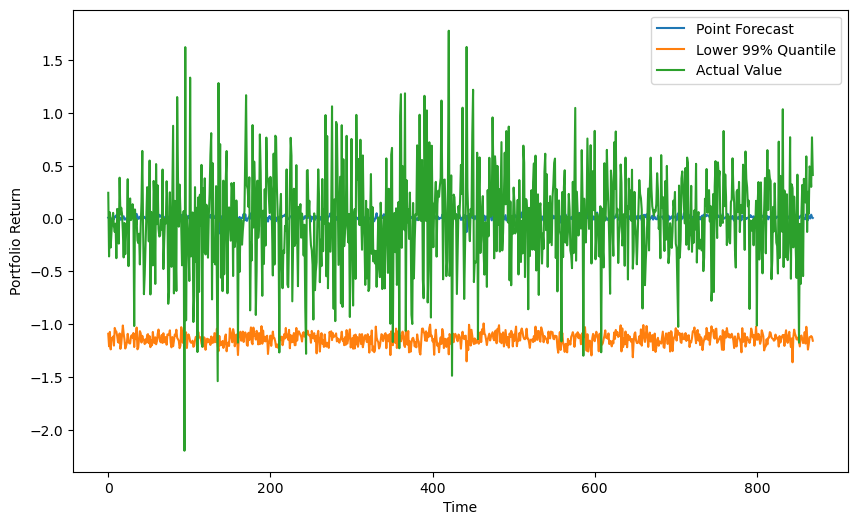

In [93]:
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)

point_forecasts, lower_quantiles, actual_values = generate_forecasts(model, test_loader, portfolio_weights, device=device)

plt.figure(figsize=(10, 6))
plt.plot(point_forecasts, label='Point Forecast')
plt.plot(lower_quantiles, label='Lower 99% Quantile')
plt.plot(actual_values, label='Actual Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.legend()
plt.show()

In [94]:
act_v = []
for i in range(test_dataset.tensors[0].shape[0]):
    act_v.append(torch.matmul(test_dataset.tensors[0][i][-1], portfolio_weights).item())

In [95]:
lower_quantiles_renorm = [v * data.std().mean() + data.mean().mean() for v in lower_quantiles]

In [96]:
act_v_renorm = [v * data.std().mean() + data.mean().mean() for v in act_v]
point_forecasts_renorm = [v * data.std().mean() + data.mean().mean() for v in point_forecasts]

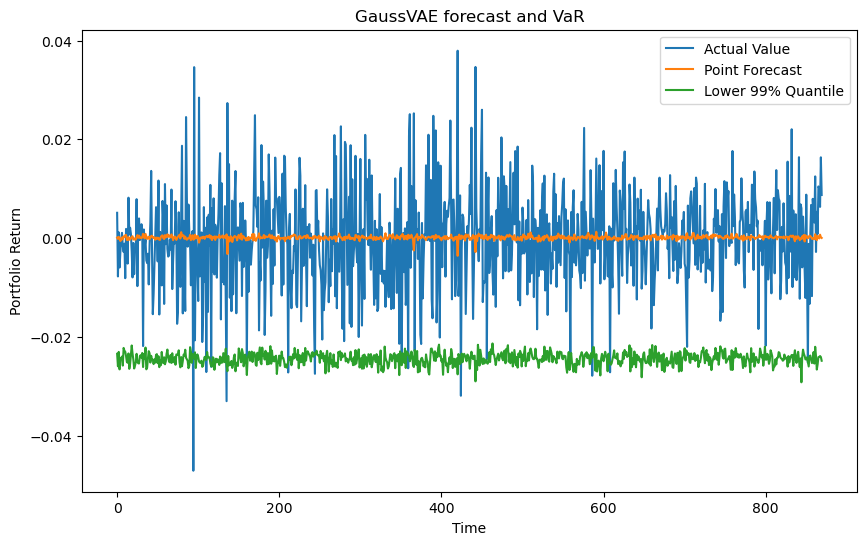

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(act_v_renorm, label='Actual Value')
plt.plot(point_forecasts_renorm, label='Point Forecast')
plt.plot(lower_quantiles_renorm, label='Lower 99% Quantile')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.legend()
plt.title("GaussVAE forecast and VaR")
plt.savefig(f"GaussVAE_forecast_plot.png")
plt.show()

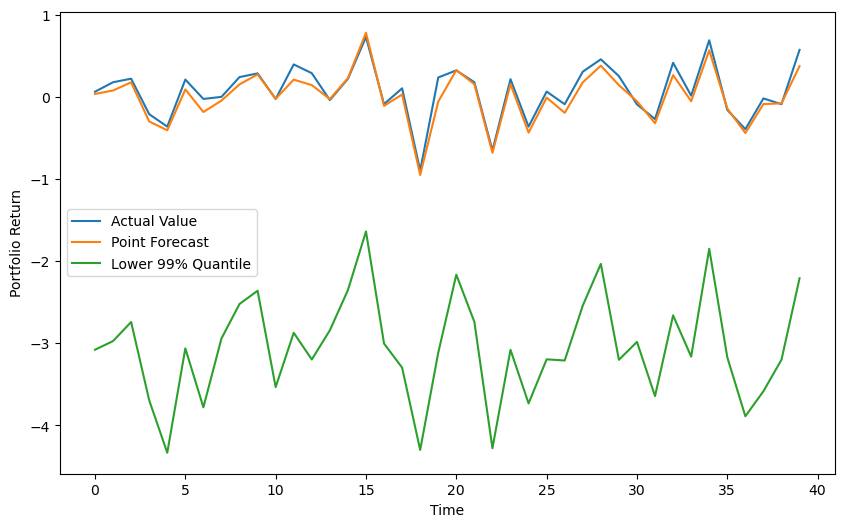

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(act_v[-40:], label='Actual Value')
plt.plot(point_forecasts[-40:], label='Point Forecast')
plt.plot(lower_quantiles[-40:], label='Lower 99% Quantile')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.legend()
plt.show()

870 870


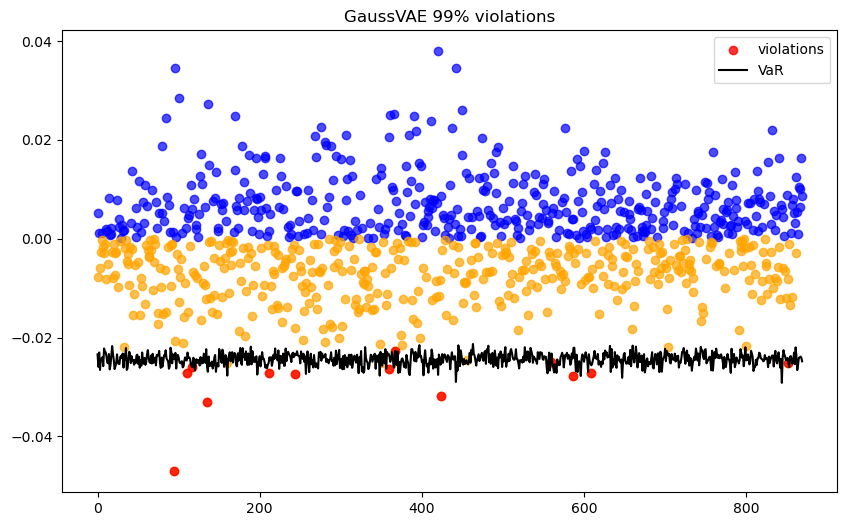

In [98]:
import matplotlib.pyplot as plt

# Assuming act_v and lower_quantiles are lists of the same length
portfolio = act_v_renorm
var_values = lower_quantiles_renorm
print(len(portfolio), len(var_values))

# Create a DataFrame to store the data
var_df = pd.DataFrame({'Returns': portfolio, 'VaR': var_values}, index=range(0, len(act_v)))

# Separate positive and negative returns
pos = var_df[var_df['Returns'] >= 0]
neg = var_df[var_df['Returns'] < 0]

# Calculate violations
var_df['Violation'] = (var_df['Returns'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == 1]

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(pos.index, pos['Returns'], c='blue', alpha=0.7)
plt.scatter(neg.index, neg['Returns'], c='orange', alpha=0.7)
plt.scatter(breakdowns.index, breakdowns['Returns'], c='red', alpha=0.8, label='violations')
plt.plot(var_df.index, var_df['VaR'], label='VaR', c='black')

plt.legend()
plt.title("GaussVAE 99% violations")
plt.savefig(f"GaussVAE_breakdown_plot.png")
plt.show()

In [99]:
var_df.to_csv('GaussVAE_predictions.csv', index=False)

# Metrics

In [100]:
import numpy as np
from scipy.stats import chi2, norm
import pandas as pd

def pof_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Kupiec's Proportion of Failure Test (POF). Tests that the number of exceptions
    corresponds to the VaR confidence level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of POF test.
    """
    exception = target < var
    t = len(target)
    m = exception.sum()
    p = 1 - alpha
    lr_pof = -2 * (m * np.log(p / (m / t)) + (t - m) * np.log((1 - p) / (1 - m / t)))
    pvalue = 1 - chi2.cdf(lr_pof, df=1)
    return pvalue

def berkowitz_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Berkowitz Test assesses the calibration of VaR forecasts. It tests whether the realized
    losses are consistent with the predicted VaR level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of the Berkowitz test.
    """
    z = (target - var.mean()) / var.std()
    lr_berkowitz = -2 * (np.log(norm.cdf(z)).sum() - np.log(alpha) * (target < var).sum() - np.log(1 - alpha) * (target >= var).sum())
    pvalue = 1 - chi2.cdf(lr_berkowitz, df=1)
    return pvalue

def quantile_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Quantile loss also known as Pinball loss. Measures the discrepancy between
    true values and a corresponding 1-alpha quantile.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        The average value of the quantile loss function.
    """
    return np.where(target < var, alpha * (var - target), (1 - alpha) * (target - var)).mean()

def quadratic_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, a: float = 1.0) -> float:
    """
    Quadratic Loss measures the squared difference between the predicted VaR and returns,
    penalizing negative returns with weight (return - VaR)^2 and negative VaRs with
    weight -a * VaR.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter for return - VaR. Default is 0.99.
        a: Weight parameter for negative VaRs. Default is 1.

    Returns:
        Quadratic Loss value.
    """
    return np.where(target < var, (target - var)**2, -a * var).mean()

def smooth_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, d: float = 25.0) -> float:
    """
    Smooth Loss penalizes observations for which return - VaR < 0 more heavily with weight (1-alpha).

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.
        d: Parameter Default is 25.

    Returns:
        Smooth Loss value.
    """
    return ((alpha - (1 + np.exp(d * (target - var)))**(-1)) * (target - var)).mean()

def tick_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Tick Loss penalizes exceedances with weight alpha and non-exceedances with weight 1 - alpha.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.

    Returns:
        Tick Loss value.
    """
    return ((alpha - (target < var).astype(float)) * (target - var)).mean()

def avg_exceedances(var: np.ndarray, target: np.ndarray) -> float:
    """
    Calculate the average number of exceedances.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Average number of exceedances.
    """
    exceedances = (target < var).sum()
    return exceedances / len(target)

def regulatory_loss(var: np.ndarray, target: np.ndarray) -> float:
    """
    Regulatory Loss Function penalizes exceedances with squared difference and non-exceedances with 0.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Regulatory Loss value.
    """
    return np.where(target < var, (var - target)**2, 0).mean()

def metrics(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> dict:
    metrics_dict = {}

    metrics_dict['POF Test p-value'] = pof_test(var, target, alpha)
    metrics_dict['Berkowitz Test p-value'] = berkowitz_test(var, target, alpha)
    metrics_dict['Quantile Loss'] = quantile_loss(var, target, alpha)
    metrics_dict['Quadratic Loss'] = quadratic_loss(var, target, alpha)
    metrics_dict['Smooth Loss'] = smooth_loss(var, target, alpha)
    metrics_dict['Tick Loss'] = tick_loss(var, target, alpha)
    metrics_dict['Average Exceedances'] = avg_exceedances(var, target)
    metrics_dict['Regulatory Loss'] = regulatory_loss(var, target)

    return metrics_dict

def calculate_metrics_table(target: pd.Series, predictions_dict: dict, alpha: float = 0.99) -> pd.DataFrame:
    metrics_list = [
        'POF Test p-value',
        'Berkowitz Test p-value',
        'Quantile Loss',
        'Quadratic Loss',
        'Smooth Loss',
        'Tick Loss',
        'Average Exceedances',
        'Regulatory Loss'
    ]
    metrics_table = pd.DataFrame(index=metrics_list)

    for model, predictions in predictions_dict.items():
        metrics_dict = metrics(predictions, target, alpha)
        metrics_table[model] = metrics_dict.values()

    return metrics_table

In [101]:
metr = metrics(var_df['VaR'], var_df['Returns'])
pd.DataFrame.from_dict(metr, orient='index', columns=['Value']).to_csv("GaussVAE_metrics.csv", index=True)
metr

{'POF Test p-value': 0.17218824771608088,
 'Berkowitz Test p-value': 1.0,
 'Quantile Loss': 0.00030394281752067965,
 'Quadratic Loss': 0.024011840573291858,
 'Smooth Loss': 0.015890546824023636,
 'Tick Loss': 0.0239735590209317,
 'Average Exceedances': 0.014942528735632184,
 'Regulatory Loss': 7.709600006979335e-07}